In [1]:
import tensorflow as tf

from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import tensorflow_model_optimization as tfmot

import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, pickle, sys, time
import shutil
import json
from scipy.io import  wavfile
from IPython import display

import str_ww_util as util
import get_dataset
import keras_model as models

from IPython import display

In [2]:
from get_dataset import get_data, get_file_lists, get_data_config

In [3]:
# jupyter will pass an extra -f=<tmp_file> arg, which throws an 
# unrecognized argument error
sys.argv = sys.argv[0:1] 

Flags = util.parse_command("train")

In [4]:
notebook_mode = "inference" # "inference" OR "short_training" OR "full_training"
tfl_file_name = "trained_models/str_ww_quant_model.tflite"
random_seed = 2024

if notebook_mode == "inference": 
  load_pretrained_model = True
  Flags.num_samples_training = 2000 # we don't need the full set for inference
  save_model = False
elif notebook_mode == "short_training":
  ## Set these for an extra short test just to validate that the code runs
  load_pretrained_model = False
  save_model = False
  Flags.num_samples_training = 2000
  Flags.num_samples_validation = 1000
  Flags.num_samples_test = 1000
  Flags.epochs = 10
elif notebook_mode == "full_training":
  ## Set these to for a full training run.
  load_pretrained_model = False # True to load from a file, False to build/train from scratch
  save_model = True
else:
  # Or make custom settings here
  pass

# 'trained_models/str_ww_model.h5' is the default save path for train.py
pretrained_model_path = 'trained_models/str_ww_ref_model.h5' # path to load from if load_pretrained_model is True

samp_freq = Flags.sample_rate

In [5]:
rng = np.random.default_rng(random_seed)

In [6]:
try:
    with open('streaming_config.json', 'r') as fpi:
        streaming_config = json.load(fpi)
    Flags.data_dir = streaming_config['speech_commands_path']
except:
    raise RuntimeError("""
        In this directory, copy streaming_config_template.json to streaming_config.json
        and edit it to point to the directories where you have the speech commands dataset
        and (optionally) the MUSAN noise data set.
        """)
Flags.bg_path = Flags.data_dir

In [7]:
ds_train, ds_test, ds_val = get_dataset.get_all_datasets(Flags)

About to get val data. 

2025-05-17 09:37:48.711458: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-17 09:37:48.711477: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-17 09:37:48.711482: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-05-17 09:37:48.711504: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-17 09:37:48.711738: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Building dataset with 2796 targets, 1398 silent, and 9786 other.
About to get train data. Building dataset with 400 targets, 200 silent, and 1400 other.
About to get test data. Building dataset with 3088 targets, 1544 silent, and 10810 other.
Done building datasets


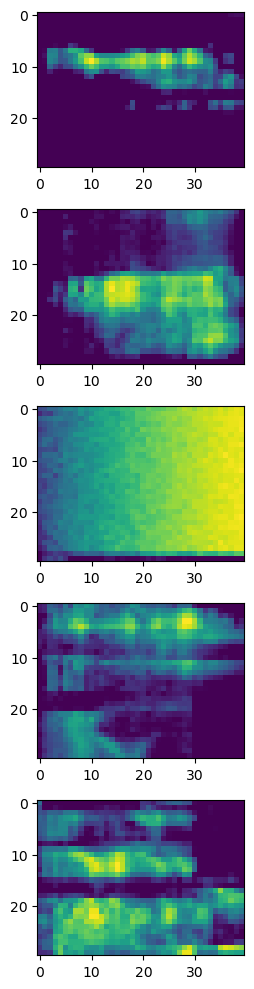

In [8]:
plt.figure(figsize=(10,10))
for i,(x,y) in enumerate(ds_train.unbatch()):
  if i < 5:
    plt.subplot(5,1,i+1)
    plt.imshow(np.squeeze(x))
  else:
    max_val = np.max(x)
plt.tight_layout()
    

In [9]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break


One element from the training set has shape:
Input tensor shape: (30, 1, 40)
Label shape: (3,)
Label : [0. 0. 1.]


These next two cells can be quite slow in the current implementation, so uncomment if you want to see them.
They
1. Show spectra of some target words
2. Count the distribution of classes in the training set

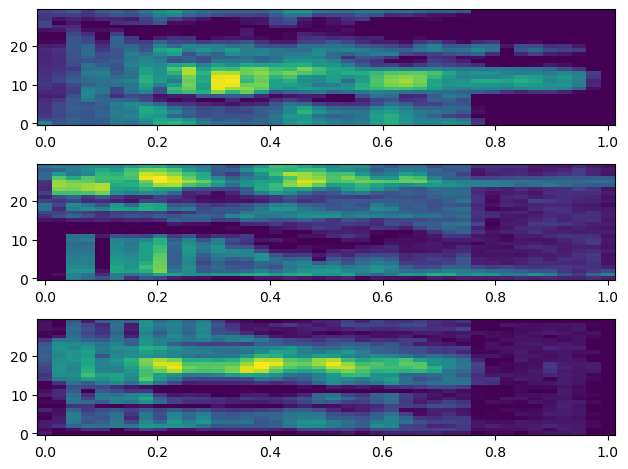

In [10]:
max_target_examples = 3
target_count = 0

plt.Figure(figsize=(10,4))
for dat in ds_train.unbatch():
  if np.argmax(dat[1]) == 0:
    target_count += 1
    ax = plt.subplot(max_target_examples, 1, target_count)
    # display.display(display.Audio(dat[0].numpy(), rate=16000))

    log_spec = dat[0].numpy().squeeze()
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, 1.0, num=width, dtype=float)
    Y = range(height)
    ax.pcolormesh(X, Y, np.squeeze(log_spec))
    if target_count >= max_target_examples:
      break
plt.tight_layout()

In [11]:
## look at the label breakdown in the training set
print(get_dataset.count_labels(ds_train))



{2: 1400, 0: 400, 1: 200}


## Build and Train Model

In [12]:
if load_pretrained_model:
  print(f"Loading pretrained model from {pretrained_model_path}")
  with tfmot.quantization.keras.quantize_scope(): # needed for the QAT wrappers
    model = keras.models.load_model(pretrained_model_path)
else:
  print(f"Building model from scratch")
  model = models.get_model(args=Flags, use_qat=Flags.use_qat) # compile step is done inside get_model()

Loading pretrained model from trained_models/str_ww_ref_model.h5


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1, 40)]       0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 28, 1, 40)         120       
 eConv2D)                                                        
                                                                 
 conv2d (Conv2D)             (None, 28, 1, 128)        5120      
                                                                 
 batch_normalization (Batch  (None, 28, 1, 128)        512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 1, 128)        0         
                                                                 
 dropout (Dropout)           (None, 28, 1, 128)        0     

In [14]:
if not load_pretrained_model:
  callbacks = util.get_callbacks(args=Flags)
  train_hist = model.fit(ds_train, validation_data=ds_val, callbacks=callbacks,
                         epochs=Flags.epochs)

In [15]:
if save_model:
  model.save('trained_models/str_ww_model_nb.h5')

In [16]:
if not load_pretrained_model:
  plt.subplot(2,1,1)
  plt.semilogy(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['categorical_accuracy'], train_hist.history['val_categorical_accuracy'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')


In [17]:
## This cell can be slow with QAT enabled
print(f"Eval on training set")
model.evaluate(ds_train)
print(f"Eval on validation set")
model.evaluate(ds_val)

Eval on training set


2025-05-17 09:37:57.467721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 17ms/step - loss: 0.3164 - categorical_accuracy: 0.9755 - precision: 0.9974 - recall: 0.9475
Eval on validation set
140/140 [==============================] - 35s 251ms/step - loss: 0.1784 - categorical_accuracy: 0.9600 - precision: 0.9821 - recall: 0.7446   


[0.17839300632476807,
 0.960014283657074,
 0.9820754528045654,
 0.7446351647377014]

In [18]:
def build_and_plot_confusion_matrix(model, dataset, label_list=['marvin', 'silent', 'other']):
  dataset = dataset.cache() # prevent shuffling between where we get predictions and where we get labels
  model_out = model.predict(dataset)
  model_out = np.squeeze(model_out)
  y_pred_val = np.argmax(model_out, axis=1)
  
  y_true_val = np.nan*np.zeros(y_pred_val.shape[0])
  for i,dat in enumerate(dataset.unbatch()):
    y_true_val[i] = np.argmax(dat[1])
  
  acc = sum(y_pred_val == y_true_val) / len(y_true_val)
  print(f'Accuracy: {acc:.1%}')

  confusion_mtx = tf.math.confusion_matrix(y_true_val, y_pred_val) 
  plt.figure(figsize=(6, 6))
  sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
              annot=True, fmt='g')
  plt.gca().invert_yaxis() # flip so origin is at bottom left
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

20/20 [==============================] - 0s 2ms/step
Accuracy: 97.5%


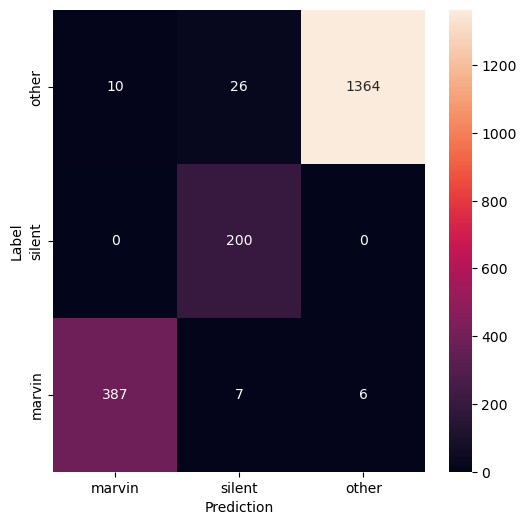

In [19]:
build_and_plot_confusion_matrix(model, ds_train)

## Post-Training Quantization

In [20]:
!python quantize.py --saved_model_path=trained_models/str_ww_ref_model.h5 \
                    --tfl_file_name=$tfl_file_name


/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
Wrote to trained_models/str_ww_quant_model.tflite


#### Test Quantized Interpreter on One Spectrogram

In [21]:
tfl_file_name = 'trained_models/strm_ww_int8.tflite'

In [22]:
interpreter = tf.lite.Interpreter(model_path=tfl_file_name)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
output_data = []
labels = []
input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [23]:
spec, label = next(ds_val.unbatch().batch(1).take(1).as_numpy_iterator())

spec_q = np.array(spec/input_scale + input_zero_point, dtype=np.int8)

interpreter.set_tensor(input_details[0]['index'], spec_q)
interpreter.invoke()
out_vec = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(out_vec)
out_vec_dequant = (out_vec.astype(np.float32) - output_zero_point)*output_scale

print(f"Output = {out_vec}.")
print(f"True (vs predicted) label = {np.argmax(label)} (vs {pred_label})")
print(f"Dequantized output vector = {out_vec_dequant}")

Output = [[-128 -128  127]].
True (vs predicted) label = 2 (vs 2)
Dequantized output vector = [[0.         0.         0.99609375]]


#### Now Measure Quantized Accuracy on Validation Set

In [24]:
t0 = time.time(); 
predictions = []
labels = []
# num_test_samples = 100

eval_ds = ds_val # ds_val OR ds_train OR ds_test

for next_spec, next_label in eval_ds.unbatch().batch(1): # .take(num_test_samples):    
  spec_q = np.array(next_spec/input_scale + input_zero_point, dtype=np.int8)
  interpreter.set_tensor(input_details[0]['index'], spec_q)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  predictions.append(np.argmax(interpreter.get_tensor(output_details[0]['index'])))
  labels.append(next_label[0])

predictions = np.array(predictions)
labels = np.argmax(np.array(labels), axis=1)
num_correct = np.sum(labels == predictions)
acc = num_correct / len(labels)
print(f"Accuracy = {acc:5.3f} ({num_correct}/{len(labels)})")
t1 = time.time(); 
print(f"Measured validation accuracy in {t1-t0} s")

Accuracy = 0.957 (13377/13980)
Measured validation accuracy in 19.551474809646606 s


As of 12 Aug 2024, the quantized accuracy on the validation set is 95.5%.  Now we can plot the confusion matrix of the quantized model.

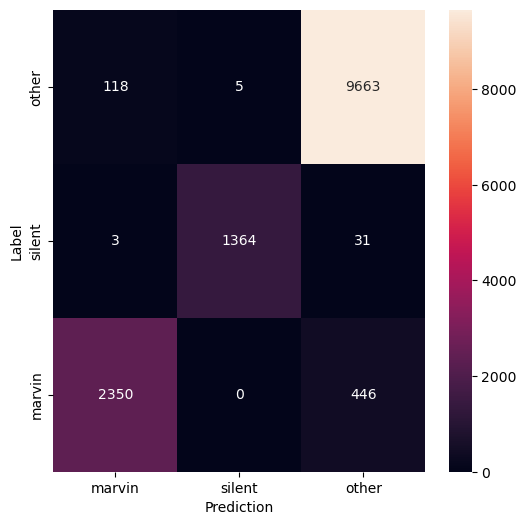

In [25]:
label_list = ['marvin', 'silent', 'other']
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run Model on Long Waveform

The use case this benchmark is meant to model is one of detecting a "wakeword" (similar to "Hey Siri", "Alexa", or "OK Google") in a continuous stream of sound, including background noise.  So to mimic that use case, we will run the model on a longer waveform that includes several instances of the wakeword ("Marvin") and some background noise.

In [26]:
if streaming_config['musan_path'] is None or len(streaming_config['musan_path']) == 0:
  raise RuntimeError("Stopping before the long-wave test, which requires the musan dataset in streaming_config['musan_path']")

In [27]:
def trim_and_normalize(wav_in, rel_thresh):
  """
  Trims leading and trailing 'quiet' segments, where quiet is defined as 
  less than rel_thresh*max(wav_in).
  Then scales such that RMS of trimmed wav = 1.0
  """
  idx_start = np.min(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  idx_stop  = np.max(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  
  wav_out = wav_in[idx_start:idx_stop]
  wav_out = wav_out / np.std(wav_out) 
  return wav_out

For the keras model, we can build an alternate version of the model that accepts inputs of arbitrary length.

In [28]:
pretrained_model_uses_qat = hasattr(model.layers[1], "quantizer")
Flags.variable_length=True
model_tv = models.get_model(args=Flags, use_qat=pretrained_model_uses_qat)
Flags.variable_length=False
# transfer weights from trained model into variable-length model
model_tv.set_weights(model.get_weights())

Input shape = [None, 1, 40]
Apple Silicon platform detected. Using legacy adam as standard Keras Adam is slow on this processor.


## Run Streaming Test on Long Waveform

A pre-constructed test wav is included in the repo (`long_wav.wav`) along with a json file that indicates the beginning and end of every instance of the wakeword, `long_wav_ww_windows.json`.

In [29]:
test_config_file = '../../runner/sww_data_dir/sww_long_test.json' 
# test_config_file = '../../runner/sww_data_dir/sww_short_test.json'
# test_config_file = '../../runner/sww_data_dir/sww_5s_dbg.json' 

with open(test_config_file, 'r') as fpi:
  stream_test_config = json.load(fpi)

ww_windows = stream_test_config[0]['detection_windows']

wav_file_path = os.path.join("../../runner/sd_card/", stream_test_config[0]['wav_file'], )
wav_sampling_freq, long_wav = wavfile.read(wav_file_path)
# wav_sampling_freq, long_wav = wavfile.read("../../runner/sd_card/med_5m.wav")
assert wav_sampling_freq == samp_freq
t = np.arange(len(long_wav))/samp_freq
print(f"min/max of long wav = {np.min(long_wav)} / {np.max(long_wav)}")
long_wav = long_wav / 2**15 # scale into [-1.0, +1.0] range

if len(long_wav.shape)==2:
  long_wav = long_wav[:,0]

# construct waveform that shows when wakeword is present
ww_present = np.zeros(len(long_wav))
for t_start, t_stop in ww_windows:
  idx_start = int(t_start*samp_freq)
  idx_stop  = int(t_stop*samp_freq)
  ww_present[idx_start:idx_stop] = 1

min/max of long wav = -32768 / 27775


In [30]:
## build a feature extractor that can operate on longer waveforms
## this one can operate on waveforms up to len(long_wav)
data_config_long = get_dataset.get_data_config(Flags, 'training')

with open("data_config_nb.json", "w") as fpo:
    json.dump(data_config_long, fpo, indent=4)
              
# long_wav = long_wav / np.max(np.abs(long_wav)) # scale into [-1.0, +1.0] range
t = np.arange(len(long_wav))/samp_freq

feature_extractor_long = get_dataset.get_lfbe_func(data_config_long)

# long_spec = feature_extractor_long(np.expand_dims(long_wav, 0)).numpy()
long_spec = feature_extractor_long(long_wav).numpy()

4 false detections.
40 true detections.
10 false rejections.


/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


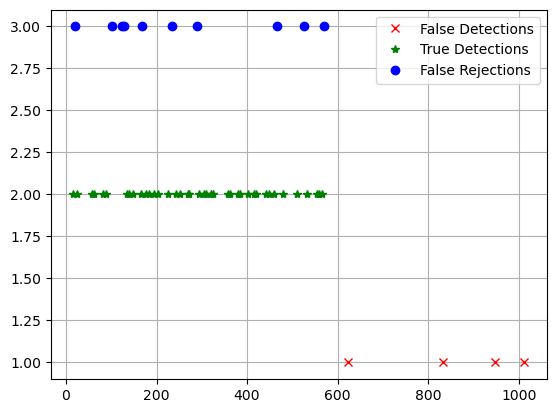

In [31]:
# we'll count a detection when the softmax output for the wakeword exceeds the detection threshold det_thresh
det_thresh = 0.95

yy = model_tv(np.expand_dims(long_spec, 0))[0].numpy()
## shows detection when ww activation > thresh
ww_detected_spec_scale = (yy[:,0]>det_thresh).astype(int)
ww_true_detects, ww_false_detects, ww_false_rejects = util.get_true_and_false_detections(ww_detected_spec_scale, ww_present, Flags)

print(f"{np.sum(ww_false_detects!=0)} false detections.")
print(f"{np.sum(ww_true_detects!=0)} true detections.")
print(f"{np.sum(ww_false_rejects!=0)} false rejections.")

plt.plot(t, 1*util.zero2nan(ww_false_detects),   'rx', label='False Detections')
plt.plot(t, 2*(util.zero2nan(ww_true_detects)),  'g*', label='True Detections')
plt.plot(t, 3*(util.zero2nan(ww_false_rejects)), 'bo', label='False Rejections')
plt.legend()
plt.grid(True)

Take a look at some of the false positives here, and then in the next cell, some of the false negatives.

In [32]:
num_fp_clips_to_show = np.minimum(5, np.sum(ww_false_detects, dtype=np.int32))
for i in range(num_fp_clips_to_show):
  fp_start = np.nonzero(ww_false_detects)[0][i] # sample number where the false pos starts
  print(f"False positive at {fp_start/samp_freq:3.2f}s (sample {fp_start})")
  fp_clip = slice(fp_start-16000,fp_start+16000) # add 2s before and after
  display.display(display.Audio(long_wav[fp_clip], rate=16000))


False positive at 622.72s (sample 9963520)


False positive at 831.33s (sample 13301248)


False positive at 947.52s (sample 15160320)


False positive at 1011.58s (sample 16185344)


In [33]:
num_fn_clips_to_show = np.minimum(5, np.sum(ww_false_rejects, dtype=np.int32))
for i in range(num_fn_clips_to_show):
  fn_start = np.nonzero(ww_false_rejects)[0][i]
  print(f"False negative at {fn_start/samp_freq:3.2f}s (sample {fn_start})")
  fn_clip = slice(fn_start-16000,fn_start+16000)
  display.display(display.Audio(long_wav[fn_clip], rate=16000))


False negative at 20.00s (sample 320003)


False negative at 101.56s (sample 1624958)


False negative at 124.68s (sample 1994876)


False negative at 128.89s (sample 2062194)


False negative at 167.98s (sample 2687741)


In [34]:
def examine_clip(wav_clip, model, feature_extractor):
    # clip_spec = feature_extractor({'audio':wav_clip, 'label':[0.0, 0.0, 0.0]})['audio'].numpy()
    clip_spec = feature_extractor(wav_clip).numpy()
    spec_len = int(1.1*len(wav_clip)/(Flags.sample_rate*Flags.window_stride_ms/1000))
    clip_spec = clip_spec[:spec_len,:]
    yy_clip = model(np.expand_dims(clip_spec, 0))[0].numpy()

    plt.subplot(3,1,1)
    t_wav= np.arange(len(wav_clip))/Flags.sample_rate
    plt.plot(t_wav, wav_clip)
                     
    plt.subplot(3,1,2)
    # plt.imshow(clip_spec.squeeze().T, origin="lower", aspect="auto");
    t_spec= np.arange(clip_spec.shape[0])*(Flags.window_stride_ms/1000)
    mels = np.arange(clip_spec.shape[-1])
    plt.pcolormesh(t_spec, mels, clip_spec.squeeze().T)
  
    plt.subplot(3,1,3)
    t_yy= np.arange(yy_clip.shape[0])*(Flags.window_stride_ms/1000)
    print(f"t_yy shape = {t_yy.shape}, yy_clip shape = {yy_clip.shape}")
    
    plt.plot(t_yy, yy_clip, [0,t_yy[-1]], [det_thresh, det_thresh]);
    plt.legend(label_list+[f"Threshold ({det_thresh})"], loc='lower left', fontsize=8);
   
    display.display(display.Audio(wav_clip, rate=16000))
    plt.tight_layout()



Now we can take a closer look at one of the errors, showing the waveform plot, listening to the audio, and showing the spectrogram, along with the model outputs.  

Examining clip from 9931520 to 9995520
t_yy shape = (95,), yy_clip shape = (95, 3)


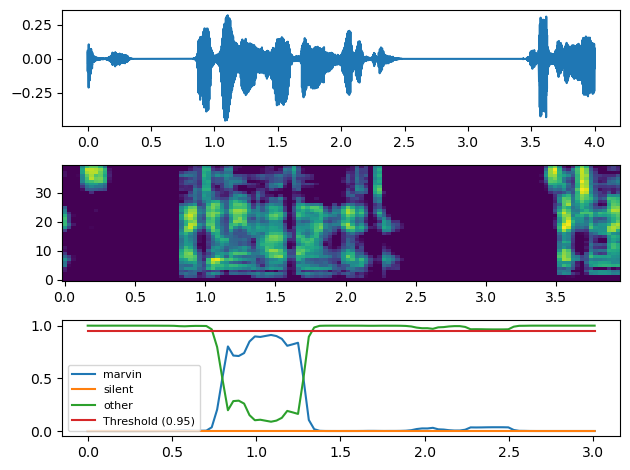

In [35]:
error_idx = 0  # which false pos/neg to look at
# you can replace ww_false_detects with ww_false_rejects to view false negatives
clip_idx = np.nonzero(ww_false_detects)[0][error_idx] 
clip_range = slice(clip_idx-2*Flags.sample_rate,clip_idx+2*Flags.sample_rate)
print(f"Examining clip from {clip_range.start} to {clip_range.stop}")
wav_clip = long_wav[clip_range]
examine_clip(wav_clip, model_tv, feature_extractor_long)


## Quantized Model on Long Wave

In [36]:
def run_tfl_model(tfl_interpreter, input_features):
  input_details = tfl_interpreter.get_input_details()
  input_shape = input_details[0]['shape']
  input_scale, input_zero_point = input_details[0]["quantization"]
  
  output_details = tfl_interpreter.get_output_details()
  output_shape = output_details[0]['shape']

  num_frames = input_features.shape[0]-input_shape[1]+1
  
  yy_q = np.nan*np.zeros((num_frames, output_shape[1]), dtype=np.int8)
  if input_features.dtype.kind in ['i', 'u']: # matches any int or unsigned int
    # assume already quantized
    longspec_q = input_features
  elif input_features.dtype.kind == 'f':  # matches any float
    # we need to quantize
    longspec_q = np.array(input_features/input_scale + input_zero_point, dtype=np.int8)

  # ensure singleton batch, feature dimension
  longspec_q = np.expand_dims(np.squeeze(longspec_q), [0,2])
  preds_q = []
  labels = []
  
  for idx in range(num_frames):
    spec_q = longspec_q[0:1, idx:idx+input_shape[1],:,:]
    
    tfl_interpreter.set_tensor(input_details[0]['index'], spec_q)
    tfl_interpreter.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    yy_q[idx,:] = tfl_interpreter.get_tensor(output_details[0]['index'])
  
  # Dequantize so that softmax output is in range [0,1]
  # yy_deq = (yy_q.astype(np.float32) - output_zero_point)*output_scale

  print(f"type:{yy_q.dtype}, min={np.min(yy_q)}, max={np.max(yy_q)}")
  
  
  return yy_q

In [75]:
# long_spec = hw_feats.astype(np.int8).T


In [76]:

t1 = time.time(); 
print(f"Ran quantized model on long wave in {t1-t0:1.2f} s")
t0 = time.time(); 
yy_q = run_tfl_model(interpreter, long_spec)
yy_deq = (yy_q.astype(np.float32) - output_zero_point)*output_scale


Ran quantized model on long wave in 17.11 s
type:float64, min=-128.0, max=127.0


In [80]:
det_thresh = 0.95
det_thresh_q = int(det_thresh/output_scale + output_zero_point)

## shows detection when wakeword activation is strongest output
# ww_detected_spec_scale = (np.argmax(yy, axis=1)==0) # detections on the time scale of spectrograms

## shows detection when ww activation > thresh
ww_detected_spec_scale = (yy_q[:,0]>det_thresh_q).astype(int)

ww_detected_spec_scale = (hw_acts_i2s >det_thresh_q).astype(int)

ww_true_detects, ww_false_detects, ww_false_rejects = util.get_true_and_false_detections(ww_detected_spec_scale, ww_present, Flags)

print(f"{np.sum(ww_false_detects!=0)} false detections.")
print(f"{np.sum(ww_true_detects!=0)} true detections.")
print(f"{np.sum(ww_false_rejects!=0)} false rejections.")

7 false detections.
40 true detections.
10 false rejections.


In [48]:
det_thresh_q

115

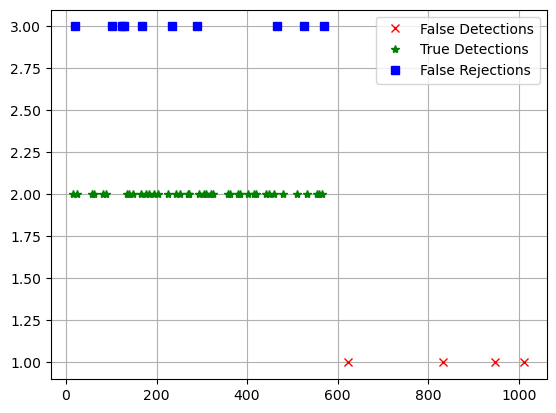

In [40]:
plt.plot(t, 1*util.zero2nan(ww_false_detects),   'rx', label='False Detections')
plt.plot(t, 2*(util.zero2nan(ww_true_detects)),  'g*', label='True Detections')
plt.plot(t, 3*(util.zero2nan(ww_false_rejects)), 'bs', label='False Rejections')
plt.legend()
plt.grid(True)

## Scratch Space


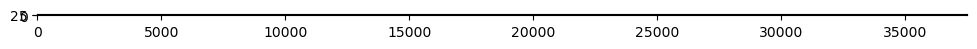

In [62]:
fname = "../../runner/long_spec_full_v1.npz"
# fname = "../../runner/specgram.npz"
# idx = slice(32450, 32600)
idx=slice(0, None)
dat = np.load(fname)
hw_feats = dat["specgram"].T
hw_activations = dat.get('activations')
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.imshow(hw_feats[:,idx], origin="lower")

if hw_activations:
  plt.subplot(2,1,2)
  plt.plot(hw_activations)
  plt.legend(label_list)

In [ ]:
np.max(hw_activations[:,0])

In [ ]:
plt.clf()
sw_activations = yy_q[:,0]
plt.plot(np.arange(hw_activations.shape[0]-30), hw_activations[30:], label='HW')
plt.plot(np.arange(sw_activations.shape[0]), sw_activations, label='SW')
plt.plot(np.arange(hw_acts_i2s.shape[0]-30), hw_acts_i2s[30:], label='HW i2s')
plt.legend()

In [ ]:
# look at 20250517_074152

In [ ]:
np.max(hw_activations[:,0])

In [ ]:
plt.plot(hw_acts_i2s)

In [42]:
hw_acts_i2s = np.array(
   [-128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -124, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -99, -9, -80,
   -37, -53, -53, -68, -74, -86, 28, 124, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 121, 91, 37, -74, -28, -121, -127,
   -128, -128, -128, -128, -128, -126, -125, -124, -123, -120, -120, -120, -120, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -121, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -126, -126, -125, -126,
   -126, -123, -124, -126, -124, -123, -123, -123, -120, -123, -123, -121, -118, -122, -124, -125,
   -123, -122, -115, -122, -124, -126, -127, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -125, -126, -127, -127, -126, -124, -121, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -103, -106,
   -113, -103, -103, -99, 86, 109, 115, 123, 117, 115, 115, 115, 118, 115, 117, 118,
   118, 117, 118, 120, 121, 118, 103, 113, 117, 106, 109, 53, -117, -115, -117, -120,
   -117, -120, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -120, -120, -123, -124, -124, -124,
   -124, -95, 0, 68, 61, 53, 45, 61, 37, 74, 103, 118, 123, 125, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   125, 111, 74, 19, -109, -127, -127, -127, -126, -123, -122, -122, -124, -125, -123, -121,
   -121, -120, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -121, 45, 123, 125, 127, 127, 127, 127, 127, 126, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 126, 125,
   111, 106, 19, -117, -121, -123, -124, -124, -123, -123, -120, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -120, -123, -127, -123, -53, 19, 80, 103, 126, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   117, -106, -128, -128, -128, -128, -127, -127, -125, -124, -123, -123, -121, -120, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -122, -115, -120, -124, -124, -126, -125, 74, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 99, -127, -128, -128, -128, -126, -122, -120, -117, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -121, -121, -121, -121, -121, -121,
   -123, -123, -123, -123, -124, -124, -125, -126, -126, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -120,
   -122, -111, -45, -103, -109, -91, -61, -19, 9, 9, -86, -95, -74, -80, -111, -125,
   -127, -128, -127, -118, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -126, -126, -125, -127, -127, -128, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -126, -125, -124, -123, -125, -127, -126, -125,
   -124, -124, -124, -106, -86, -45, 0, 9, -19, -45, -53, -28, -37, -37, -28, -19,
   -37, 0, -68, -95, -103, -120, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -126, -127, -127, -128, -127, -126, -125, -125, -126, -125, -124, -123, -123, -124,
   -126, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -127, -127, -128, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -127, -127, -126, -123, -124, -123, -121, -124, -127, -126, -125, -125, -125,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -127, -95, 80, 109,
   111, 111, 91, 68, 80, 109, 99, 106, 99, 111, 111, 111, 111, 106, 86, 61,
   61, 53, 61, 45, 0, 9, -61, 37, -53, -125, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -127, -128, -128, -128, -127, -128, -128, -128, -128, -128, -127, -126, -125, -115, -106,
   -103, -109, -106, -99, -109, -113, -113, -109, -99, -109, -117, -109, -106, -95, -80, -45,
   -45, 19, -37, -125, -126, -124, -126, -126, -127, -127, -127, -127, -126, -126, -127, -127,
   -127, -127, -127, -128, -128, -128, -127, -127, -127, -127, -127, -127, -128, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -125, -126, -127, -128, -128, -127, -127,
   -126, -127, -127, -127, -127, -126, -127, -128, -128, -128, -128, -128, -128, -128, -127, -128,
   -127, -128, -128, -128, -128, -128, -128, -128, -127, -123, -28, 95, 120, 124, 123, 125,
   120, 113, 117, 124, 117, 121, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 61, 0, -111, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -125, -126, -127, -126, -126, -125, -126, -128, -128, -127, -124,
   -126, -125, -124, -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -126, -125, -125, -127, -127, -127, -127, -126, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -126, -109, -28, -37, -19, 0, 103, 125, 126,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   124, 115, 60, -111, -127, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -125, -126, -124, -120, -118,
   -123, -123, -126, -123, -124, -123, -123, -123, -125, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -126, -126, -127, -127, -126, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -117, -118, 37, 80, 103, 95, 86, 86,
   109, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 125, 118, -28, -99, -109, -125, -126, -126, -127, -127, -126, -125, -126,
   -126, -127, -127, -127, -126, -123, -120, -122, -124, -125, -126, -126, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128,
   -127, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -126,
   -126, -125, -125, -126, -126, -126, -127, -127, -127, -126, -127, -127, -127, -128, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -125, -124, -120, -123, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -126, -37, 86, 103, 113, 115, 113, 126, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 103,
   -125, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -128, -127, -123, -109, -61, -9, 86, 68, 95,
   80, 74, 61, 74, 53, 61, 67, 45, 53, 45, 45, 45, 28, -45, -74, -91,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -125, -125, -122, -124, -126, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -125, -99, -95, -68, -28, 68,
   99, 109, 120, 127, 127, 126, 125, 125, 126, 127, 127, 127, 127, 127, 126, 126,
   127, 127, 120, 28, -61, -124, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -126, -127, -127, -128, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -126, -127, -127, -127, -127, -127, -128, -128, -128, -128, -127, -126, -127,
   -127, -128, -127, -121, 91, 103, 103, 120, 122, 118, 115, 117, 118, 122, 120, 118,
   115, 113, 113, 109, 103, 111, 106, 68, 53, 80, 61, -19, -74, -109, -121, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -128, -128, -127, -127, -127, -128, -127, -127, -127, -127, -127, -128, -128, -127, -127, -127,
   -127, -127, -127, -127, -127, -126, -125, -125, -126, -126, -124, -123, -121, -123, -124, -125,
   -124, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -127, -127, -125, -126, -126, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -126, -118, -125, -124, -123, -122, -124, -126,
   -126, -126, -123, -124, -126, -126, -125, -124, -126, -126, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -126, -123, -126, -127, -128, -128, -127, -127, -127, -127,
   -126, -125, -126, -126, -125, -125, -127, -127, -128, -127, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -126, -126, -127, -127, -121, -74, 0, 0,
   28, 28, -28, -19, 80, 118, 111, 113, 113, 103, 118, 122, 121, 121, 120, 120,
   117, 120, 123, 124, 123, 124, 118, 91, 80, 19, -120, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -126, -126, -127, -125, -126,
   -126, -127, -128, -128, -128, -127, -127, -127, -126, -126, -126, -127, -127, -127, -127, -127,
   -127, -127, -126, -127, -127, -127, -127, -127, -127, -127, -128, -128, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -128, -128, -128, -127, -127, -125, -117, -113, -19, 95, 111, 106,
   80, 106, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 95, -113, -128, -128, -128, -128, -128,
   -128, -127, -126, -127, -126, -127, -127, -124, -125, -121, -106, -103, -125, -128, -128, -128,
   -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -127,
   -127, -127, -127, -127, -127, -127, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -127,
   -127, -128, -127, -126, -118, -120, -127, -127, -127, -127, -128, -128, -127, -126, -126, -125,
   -126, -125, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128,
   -128, -128, -128, -127, -127, -126, -126, -124, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -126, -127, -127, -127, -127, -127, -127, -127, -126, -125, -122, -121, -126, -127, -127, -127,
   -126, -127, -126, -127, -127, -127, -127, -126, -127, -128, -127, -128, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127, -124, -123,
   -126, -126, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -126, -127, -127, -127, -127, -127, -125, -126, -125, -125, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -125, -125, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -127, -128, -127, -127, -126, -126, -127, -127, -127, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -126, -126, -126, -127, -127,
   -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128,
   -128, -127, -126, -126, -125, -124, -122, -122, -124, -125, -126, -127, -128, -128, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -125,
   -121, -80, -9, 53, 28, 9, 80, 123, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 123, 99, 37, -103, -127, -128,
   -128, -128, -128, -128, -128, -127, -126, -127, -127, -128, -128, -128, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -126, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -123, -125,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -128, -127, -127, -125, -124, -121, -120, -123, -126, -127, -124, -113, -124,
   -124, -125, -126, -120, -121, -117, -113, -122, -126, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -126, -127, -127, -127, -128, -128, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -122, 45, 91, 103,
   115, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 125, 28, -122, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -127, -128, -127, -128, -128, -127, -128, -128, -127,
   -126, -125, -125, -126, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -127, -127, -128, -128, -128,
   -128, -128, -127, -126, -127, -128, -128, -128, -128, -127, -128, -128, -128, -127, -128, -128,
   -128, -127, -128, -127, -127, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -126,
   -124, -120, -123, -120, -127, -127, -127, -127, -124, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128,
   -128, -128, -128, -128, -127, -127, -126, -123, -126, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -113, -111, 45, 118, 126,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 126, 126, 124, 86, -103, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -122, -122, -124, -126, -125, -124, -125, -125, -123, -124, -123, -122, -124, -125, -126,
   -127, -127, -127, -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -127,
   -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126,
   -120, -120, -118, -123, -126, -126, -126, -122, -123, -117, -122, -123, -125, -124, -122, -124,
   -120, -115, -123, -123, -125, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -128, -128, -128, -128, -127, -127, -127, -126, -126, -127, -128, -128, -128, -128, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -127, -127, -125,
   -127, -127, -128, -128, -127, -127, -127, -127, -127, -127, -126, -125, -125, -125, -127, -127,
   -127, -127, -126, -127, -126, -125, -122, -123, -124, -124, -124, -126, -126, -126, -127, -127,
   -127, -126, -126, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -126, -127, -127, -127, -126, -127, -127, -120,
   -103, 45, 74, 68, -91, -113, -106, -117, -118, -109, -118, -123, -124, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -125, -127, -128, -128, -128, -127, -127, -127, -127,
   -127, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -128, -128, -127, -127, -127, -127, -128, -127, -128, -126, -124, -125, -99,
   45, 113, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 123, 86, 0, -109, -126,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -123, -45,
   120, 124, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 124, 126, 123, -9, -125, -128, -128, -128, -128, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -126,
   -125, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -121, -123, -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -128, -127, -127,
   -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -126, -125,
   -123, -122, -118, -111, -117, -118, -121, -122, -120, -117, -120, -125, -123, -126, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128,
   -127, -126, -126, -126, -127, -126, -126, -123, -123, -117, -122, -126, -126, -124, -126, -127,
   -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -126, -127, -126, -127, -127, -128, -128,
   -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -126, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -68, -9, 9, -9, 91, 111,
   118, 113, 117, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 126, 122, 0, -122, -126, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -127, -127, -126, -126, -127, -126, -126, -126, -127, -127, -127, -126, -126, -126, -126, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -126,
   -126, -127, -127, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -125, -123, -123, -123, -122, -120, -120, -121, -120, -123, -120, -123, -115, -99, -109, -123,
   -127, -127, -127, -127, -127, -125, -125, -125, -123, -123, -121, -121, -118, -118, -118, -118,
   -118, -118, -118, -124, -126, -126, -127, -126, -126, -126, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -126, -125, -124, -123, -122, -121,
   -118, -123, -127, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -127, -126, -126, -126, -127, -127, -127, -127, -126, -126, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -128, -127, -127, -127, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -128, -128, -127, -127, -125,
   -124, -123, -124, -125, -125, -125, -124, -126, -127, -127, -121, -61, 19, 53, 61, 103,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 123, -28, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -128, -128, -128,
   -127, -126, -45, 74, 118, 124, 123, 125, 125, 122, 122, 121, 121, 122, 123, 123,
   124, 121, 117, 118, 113, 122, 118, 95, 45, -86, -127, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -127, -127, -127,
   -127, -127, -126, -125, -124, -124, -125, -125, -125, -126, -126, -126, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -126, -127, -127, -126, -126, -125,
   -125, -124, -123, -122, -123, -123, -123, -123, -124, -124, -124, -126, -127, -126, -126, -127,
   -127, -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127, -128, -127, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -126, -126, -125, -125, -125, -125, -125, -125, -126, -126, -126, -126, -126, -125,
   -125, -125, -124, -124, -124, -125, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128,
   -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -127,
   -125, -127, -127, -124, -118, -91, 95, 125, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 123, -53, -126,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -126, -126, -127, -127, -127, -127,
   -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -127, -127, -127, -127, -118, -80, -91, 19, 91, 124, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 120, 0, -127, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127,
   -126, -126, -127, -127, -127, -127, -127, -126, -127, -127, -126, -126, -126, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -126, -126, -125, -125, -125,
   -125, -125, -125, -125, -125, -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -124,
   -122, -120, -122, -123, -123, -124, -123, -124, -125, -125, -126, -124, -122, -122, -120, -123,
   -125, -126, -126, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -125,
   -121, -123, -121, -122, -120, -122, -123, -123, -120, -115, -106, -86, -95, -99, -117, -124,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -127,
   -127, -127, -127, -127, -127, -124, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -126, -126, -126,
   -126, -126, -126, -125, -123, -121, -115, -111, -113, -118, -118, -120, -118, -103, -80, -37,
   -28, 0, 61, 68, 95, 0, -61, -99, -117, -115, -109, -74, 19, 80, -9, -37,
   -74, -115, -123, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -126, -126, -126, -126, -126, -127, -127, -127, -126, -126, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -127, -127, -125,
   -124, -124, -124, -125, -125, -125, -125, -125, -124, -123, -122, -122, -125, -127, -127, -127,
   -128, -127, -127, -127, -127, -127, -127, -127, -128, -128, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -127, -126, -124, -126, -126, -127, -127, -127, -127, -127, -127, -126, -125, -124,
   -123, -123, -125, -127, -127, -127, -127, -126, -126, -126, -126, -125, -126, -127, -127, -127,
   -126, -125, -123, -124, -125, -123, -124, -125, -125, -124, -122, -125, -124, -126, -126, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -125, -123, -125, -125, -126, -127, -127, -127, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126,
   -126, -124, -125, -125, -125, -125, -125, -125, -125, -125, -126, -127, -127, -127, -127, -126,
   -125, -117, -118, -123, -123, -124, -125, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -126, -126, -125, -124, -122, -118, -120, -115, -122, -123, -123, -122, -120, -120, -124, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128,
   -128, -127, -126, -127, -127, -126, -123, -123, -124, -106, -126, -127, -128, -128, -128, -128,
   -128, -128, -127, -126, -127, -127, -127, -127, -127, -127, -127, -126, -125, -123, -118, -122,
   -122, -124, -123, -123, -95, -28, 9, 0, 37, 86, 99, 86, -37, -68, -86, -95,
   -91, -68, -19, 45, 9, -80, -99, -109, -117, -123, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -123, -124, -123,
   -123, -122, -121, -118, -117, -118, -115, -111, -95, -111, -118, -121, -121, -123, -123, -124,
   -122, -123, -118, -120, -125, -126, -126, -126, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -127, -125, -125, -124, -124, -122, -123, -123, -124,
   -124, -124, -121, -123, -123, -123, -124, -124, -124, -126, -126, -126, -126, -126, -126, -126,
   -126, -126, -124, -125, -125, -125, -127, -127, -127, -127, -127, -127, -126, -126, -126, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -126, -126, -126, -125, -124,
   -124, -123, -118, -117, -103, -106, -111, -118, -115, -115, -106, -106, -117, -111, -103, -95,
   -91, -99, -123, -127, -127, -128, -128, -128, -128, -127, -128, -127, -127, -127, -127, -127,
   -125, -124, -121, -118, -118, -113, -106, -111, -120, -117, -115, -118, -117, -122, -124, -124,
   -125, -126, -126, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -127, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -124,
   -121, -118, -118, -121, -121, -122, -123, -123, -123, -123, -125, -126, -126, -127, -127, -127,
   -127, -128, -127, -127, -127, -127, -127, -127, -126, -126, -127, -127, -127, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -127, -127, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -126, -126, -124, -124, -125, -125, -126, -126, -126, -125, -125, -124, -125, -126, -127, -127,
   -127, -127, -127, -127, -126, -126, -126, -126, -126, -127, -126, -126, -126, -127, -126, -126,
   -125, -125, -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -127, -126, -125, -124, -123, -122, -120, -115, -115, -106, -115, -118, -123, -125,
   -125, -125, -126, -126, -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -126,
   -126, -126, -126, -126, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -125, -124, -103, -74, 9, 0, 74, 121, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   126, 127, 111, -122, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -126, -126, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -121, -111,
   -109, 53, 68, 74, 123, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 126, 124, 126, 120, -99, -126, -128, -128,
   -128, -127, -125, -123, -122, -123, -123, -124, -125, -125, -126, -126, -125, -126, -126, -126,
   -125, -125, -124, -125, -125, -125, -125, -126, -126, -127, -127, -127, -127, -126, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -126,
   -125, -124, -124, -124, -123, -124, -124, -125, -126, -127, -126, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -128, -128, -128, -127, -127, -126, -126, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -126, -126, -126, -126, -126, -126, -126, -126, -126, -126, -126,
   -126, -125, -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -127, -127, -127, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127,
   -126, -125, -125, -124, -123, -124, -124, -123, -123, -123, -124, -123, -122, -122, -122, -123,
   -124, -125, -125, -124, -123, -124, -125, -126, -126, -126, -126, -127, -127, -127, -127, -126,
   -125, -124, -125, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -128, -128, -128, -128, -127, -127, -126, -126, -126, -126, -126, -126, -127, -127, -127, -127,
   -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -127, -127, -127, -127, -126, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -126, -126, -125, -123, -123, -126, -126, -126, -127, -126, -127, -126, -126, -126,
   -126, -127, -127, -127, -127, -127, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -127, -127, -127, -126, -126, -125, -124, -124, -123, -124, -124,
   -124, -126, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -126, -126, -125, -125, -124, -124, -124,
   -123, -124, -124, -122, -109, -95, -86, -80, -109, -122, -125, -125, -126, -126, -126, -125,
   -124, -123, -122, -123, -125, -126, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -126, -126, -125, -127, -127,
   -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -124, -121, -118, -121, -122, -122, -117, -19,
   37, 122, 124, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 126, 0, -109, -127, -128, -128, -127, -127, -126, -126,
   -126, -126, -126, -126, -125, -125, -127, -127, -126, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -126, -125, -126, -125, -124, -126, -126, -126, -126, -125, -123, -122, -118, -121, -123, -124,
   -124, -125, -127, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -126, -19, 91,
   103, 95, 95, 61, -53, 9, 117, 125, 126, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 126, 120, 86, 9, -109, -124, -127,
   -128, -128, -127, -126, -125, -125, -125, -125, -125, -123, -124, -123, -124, -124, -124, -124,
   -124, -125, -123, -124, -122, -118, -118, -125, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -123, -123,
   -124, -124, -123, -123, -124, -126, -126, -126, -126, -125, -125, -123, -111, -125, -127, -125,
   -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -126, -124, -120, -117, -118, -111, -103, -103, -99, -99, -106, -103, -109,
   -91, -91, -122, -126, -126, -127, -127, -127, -127, -127, -126, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -125, -126, -126, -126, -126, -127,
   -127, -126, -125, -124, -123, -123, -123, -124, -125, -126, -126, -126, -126, -126, -126, -126,
   -126, -125, -125, -125, -123, -124, -123, -123, -123, -124, -120, -122, -121, -121, -121, -123,
   -123, -117, -113, -118, -126, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -127, -127, -126, -126,
   -124, -124, -123, -122, -120, -123, -125, -126, -126, -127, -127, -127, -127, -126, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -127, -127, -126, -124, -123, -121, -122, -123, -123, -123, -120,
   -117, -120, -124, -125, -126, -127, -127, -127, -127, -127, -126, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -128, -127, -127, -126, -126, -125, -126, -126, -126, -125, -126, -127, -126, -126, -126,
   -125, -126, -125, -126, -127, -127, -127, -127, -127, -126, -126, -126, -127, -127, -127, -127,
   -127, -126, -126, -126, -124, -124, -125, -125, -126, -126, -126, -127, -126, -125, -125, -123,
   -124, -124, -124, -125, -124, -124, -124, -123, -125, -124, -124, -123, -124, -125, -127, -127,
   -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -127, -127, -127, -127, -126, -125,
   -123, -123, -122, -122, -120, -121, -122, -124, -125, -126, -126, -126, -126, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -127,
   -127, -126, -126, -126, -126, -126, -127, -127, -127, -126, -126, -126, -126, -126, -127, -127,
   -127, -127, -127, -127, -127, -127, -126, -126, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -99, -45, 61, 61, 74, 115, 126,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 113, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -126, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -125, -125, -124,
   -124, -124, -124, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -126, -126, -125, -124, -123, -124, -124, -124,
   -125, -125, -125, -125, -123, -123, -124, -124, -125, -124, -123, -122, -123, -124, -124, -124,
   -125, -125, -126, -126, -126, -126, -126, -127, -127, -127, -128, -127, -127, -128, -127, -127,
   -128, -127, -127, -128, -127, -128, -127, -127, -127, -127, -128, -128, -128, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -126, -126, -125, -125, -124, -124, -124, -125, -125,
   -126, -126, -127, -126, -127, -126, -126, -126, -126, -126, -127, -127, -127, -128, -127, -127,
   -126, -125, -126, -127, -127, -127, -127, -126, -127, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -126, -127, -126, -124, -123, -123, -123, -123, -124, -125, -126, -126, -126, -127,
   -127, -126, -127, -127, -127, -127, -127, -127, -128, -128, -128, -127, -126, -126, -126, -127,
   -127, -127, -127, -126, -127, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -126, -126, -126, -126, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -127, -126, -126, -126, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -126, -126, -126, -126, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -127, -127, -126, -126, -126, -126, -125, -125, -125,
   -125, -126, -126, -127, -127, -126, -126, -126, -126, -126, -127, -127, -127, -127, -127, -127,
   -124, -68, -19, 53, 74, 74, 113, 126, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 68,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -126, -125, -125, -125, -125, -125, -125, -125, -126, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -127, -127, -126, -123,
   -103, -74, 37, 45, -45, -86, 45, 115, 124, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 126, 127, 125, 111, -37, -113, -127, -127, -127,
   -127, -127, -126, -124, -126, -125, -126, -124, -122, -122, -122, -122, -122, -122, -123, -122,
   -121, -121, -121, -121, -122, -123, -124, -124, -123, -123, -123, -123, -123, -122, -120, -123,
   -123, -123, -123, -122, -124, -125, -126, -127, -127, -127, -127, -127, -127, -128, -128, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -128, -128, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -126, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126,
   -126, -126, -127, -126, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -127, -127, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -126, -126, -126, -125, -126, -126, -126, -125, -124, -124, -124,
   -125, -124, -125, -125, -125, -125, -126, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -126, -125, -126, -126, -126, -125, -124, -123, -121, -123, -122, -121,
   -111, -103, -80, -61, -74, -74, -103, -115, -118, -120, -123, -125, -126, -126, -126, -124,
   -126, -126, -127, -127, -126, -126, -126, -126, -127, -127, -126, -126, -126, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -127, -125, -123, -121, -121, -120, -120, -123, -123, -124,
   -124, -125, -124, -123, -122, -122, -122, -123, -123, -123, -123, -123, -123, -124, -126, -126,
   -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -127, -127,
   -127, -127, -126, -126, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128,
   -127, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -126, -127, -126,
   -126, -126, -126, -126, -125, -126, -126, -125, -126, -126, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -126, -127, -127, -127, -127, -126, -127, -126, -127, -127, -126, -125, -123,
   -125, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -127, -127, -128, -128, -128,
   -127, -127, -128, -128, -128, -128, -127, -127, -127, -128, -128, -127, -126, -126, -126, -126,
   -126, -126, -125, -125, -127, -126, -126, -126, -126, -126, -126, -126, -126, -126, -125, -123,
   -109, -103, -106, -80, -80, -61, -37, -45, -61, -74, -91, -95, -99, -106, -115, -118,
   -122, -121, -120, -115, -115, -115, -120, -121, -111, -113, -109, -111, -109, -111, -109, -109,
   -113, -115, -117, -120, -120, -120, -121, -120, -113, -106, -95, -80, -61, -37, -61, -80,
   -99, -109, -113, -121, -120, -118, -118, -121, -122, -124, -126, -126, -127, -127, -127, -127,
   -127, -128, -128, -127, -127, -127, -127, -126, -125, -124, -123, -122, -121, -121, -117, -117,
   -113, -103, -99, -103, -111, -118, -122, -122, -122, -120, -118, -121, -121, -121, -118, -111,
   -113, -115, -118, -122, -124, -121, -122, -121, -122, -123, -124, -122, -121, -122, -123, -126,
   -126, -127, -127, -127, -127, -127, -127, -126, -127, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -126, -126,
   -126, -126, -126, -126, -126, -126, -126, -126, -125, -126, -125, -124, -123, -121, -117, -117,
   -120, -118, -117, -115, -115, -115, -117, -115, -117, -118, -115, -118, -121, -123, -124, -124,
   -125, -127, -126, -127, -127, -127, -127, -127, -126, -126, -126, -126, -126, -126, -126, -126,
   -126, -126, -126, -126, -126, -126, -126, -127, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -127, -127, -126, -125, -124, -124, -123, -122, -120,
   -120, -124, -126, -127, -127, -128, -128, -128, -128, -127, -127, -125, -124, -124, -123, -123,
   -123, -121, -123, -124, -123, -123, -123, -123, -123, -123, -123, -123, -122, -123, -123, -123,
   -123, -124, -124, -125, -124, -124, -124, -124, -125, -124, -125, -125, -125, -125, -122, -28,
   80, 103, 109, 109, 117, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 125, 91, -118, -127,
   -128, -128, -127, -126, -125, -126, -126, -126, -126, -125, -124, -122, -113, -117, -121, -123,
   -123, -123, -126, -126, -125, -124, -124, -126, -127, -127, -127, -127, -127, -127, -127, -127,
   -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -125, -124,
   -123, -122, -122, -121, -121, -120, -120, -121, -121, -120, -121, -123, -125, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -126, -120,
   -37, -19, 95, 120, 118, 121, 123, 125, 126, 126, 126, 125, 125, 125, 126, 123,
   123, 118, 45, -37, -86, -99, -122, -124, -127, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -125, -123, -68, 68, 115, 122, 126, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 126, 123, 68, 28, -120,
   -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -128, -128, -128, -128, -128, -128, -127, -122, -74, -28, -28, -86, -95,
   -74, -45, 0, 68, 60, 86, 80, 74, 80, 80, 45, -68, -125, -127, -125, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -124, -117, -120, -123, -120, -126, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -127, -126, -126, -126, -126, -126, -126, -125, -125, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -126, -126, -127, -127, -127, -127, -127, -126, -124, -115, -113, -122, -124, -120,
   -121, -123, -125, -127, -127, -127, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -126, -127, -127, -126, -123, -115, -117, -120,
   -123, -126, -127, -127, -127, -127, -127, -128, -128, -128, -128, -124, -121, -121, -125, -126,
   -127, -128, -127, -127, -127, -126, -127, -127, -127, -126, -124, -124, -126, -127, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -125, -121, -80, -86, 74, 80, 113, 124, 124, 123, 124, 126, 126,
   126, 126, 126, 126, 125, 126, 126, 127, 126, 113, 74, 61, -95, -127, -126, -127,
   -127, -127, -127, -127, -127, -127, -127, -126, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -125, -125, -124, -124, -121,
   -121, -112, -112, -119, -115, -114, -109, -91, -95, -106, -106, -115, -122, -126, -127, -127,
   -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -126, -123, -121, -115, -107, -86, -94, -107, -115,
   -116, -120, -125, -125, -126, -126, -125, -125, -126, -125, -124, -127, -127, -127, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -126, -125, -124, -125, -125,
   -123, -121, -121, -118, -120, -118, -109, -91, -95, -80, -74, -68, -45, 19, 19, 0,
   -45, -68, -91, -80, -91, -111, -115, -121, -120, -123, -125, -126, -127, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -128, -128,
   -128, -127, -127, -127, -128, -128, -127, -127, -127, -127, -127, -127, -128, -128, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -128, -127, -127, -127, -127, -127, -126, -126, -126, -126,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -127, -128, -127, -127, -127, -127, -127, -127, -128, -127, -127, -127,
   -127, -127, -127, -127, -126, -127, -127, -127, -126, -127, -127, -127, -127, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -126, -126, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -125, -126, -124, -124, -126, -125, -125, -125, -125, -124,
   -124, -123, -123, -120, -118, -123, -124, -123, -126, -126, -127, -126, -126, -127, -127, -126,
   -126, -124, -122, -120, -122, -124, -125, -124, -124, -123, -124, -126, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -127, -128, -127, -127, -127, -127, -126, -126, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -126, -127, -127, -127, -127, -127, -127, -127, -127, -128, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -126, -125, -124, -125, -126, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -109,
   37, 117, 126, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 124, 28, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -125, -127, -126,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -126,
   -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -126, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -127,
   -127, -126, -124, -123, -120, -109, -113, -118, -120, -121, -118, -120, -124, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -122, -115,
   -111, -115, -115, -117, -122, -123, -124, -124, -121, -113, -120, -124, -125, -126, -127, -127,
   -127, -126, -126, -127, -127, -126, -126, -125, -125, -124, -125, -124, -127, -127, -127, -126,
   -124, -121, -123, -120, -115, -68, -10, -10, -54, -54, -63, -92, -96, -109, -103, -106,
   -111, -122, -121, -117, -91, -81, -86, -91, -109, -115, -113, -117, -121, -117, -123, -126,
   -125, -123, -122, -124, -126, -127, -127, -127, -127, -128, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -126, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127,
   -128, -128, -127, -127, -128, -127, -125, -126, -126, -126, -126, -126, -126, -127, -127, -126,
   -126, -127, -126, -127, -126, -127, -127, -127, -126, -126, -125, -123, -122, -123, -125, -125,
   -126, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -118, -113, -86, -53, -80,
   -68, -80, -19, 36, 85, 106, 99, 45, 9, -28, -37, -61, -80, -91, -95, -106,
   -115, -121, -122, -125, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -126, -126, -127, -126,
   -126, -125, -125, -125, -123, -124, -123, -124, -125, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -127, -126, -127, -127, -127, -127, -127, -127, -126, -126,
   -127, -127, -127, -127, -126, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -109, 28, 68, 74,
   111, 122, 121, 123, 124, 126, 120, 120, 115, 113, 115, 109, 103, 106, 95, 86,
   68, 68, 95, 95, -99, -113, -120, -126, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -128, -127, -127, -127, -126, -124, -124, -124, -126, -126, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -125, -126, -125, -120, -117, -117, -111, -115, -122, -125,
   -126, -125, -125, -124, -126, -126, -127, -126, -124, -125, -125, -125, -126, -125, -123, -123,
   -124, -125, -126, -125, -126, -127, -126, -126, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -125, -123,
   -118, -122, -122, -122, -123, -121, -115, -111, -118, -121, -124, -123, -123, -122, -122, -120,
   -123, -124, -126, -126, -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -127, -127, -128, -128,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -128,
   -127, -128, -128, -128, -128, -126, -123, -120, -122, -124, -125, -123, -123, -122, -122, -121,
   -118, -120, -120, -122, -124, -124, -125, -125, -123, -122, -123, -123, -124, -125, -124, -123,
   -124, -123, -124, -124, -125, -123, -123, -115, -111, -113, -117, -124, -125, -126, -125, -124,
   -124, -125, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -126, -125, -123, -123, -124, -126, -126, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -125, -123, -122, -120, -121, -121, -123, -123, -120, -121, -121,
   -123, -123, -121, -122, -121, -123, -125, -125, -124, -122, -125, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -126, -118, -111, -109, -103,
   -86, -69, -86, -103, -117, -122, -123, -124, -126, -126, -126, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -126, -120, -115, 19, 106, 122, 126, 126, 127, 127,
   124, 124, 124, 124, 124, 125, 123, 124, 125, 123, 124, 124, 125, 125, 123, 109,
   -28, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -125, -80, -37, -53, -45, -74,
   -113, -95, -45, -80, -53, -68, -91, -19, 68, 106, 118, 124, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127,
   127, 127, 126, 114, -80, -125, -124, -123, -119, -114, -125, -127, -128, -128, -128, -128,
   -128, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -126, -126, -125, -125, -125, -126, -125, -126, -126, -126, -127, -127,
   -126, -124, -124, -124, -124, -124, -126, -126, -120, -124, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -123, 19, 91, 106, 113, 111, 120, 117, 123, 127, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 127, 117, 9, -109,
   -115, -127, -128, -128, -128, -128, -128, -127, -127, -126, -127, -126, -126, -126, -126, -127,
   -127, -127, -127, -128, -128, -127, -127, -127, -127, -127, -128, -128, -128, -128, -127, -127,
   -124, -126, -126, -124, -123, -124, -126, -127, -127, -127, -128, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -126, -127, -127, -127, -127, -127, -127, -128, -128, -127, -128, -127, -127, -127, -126, -126,
   -126, -125, -126, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125,
   -118, -123, -125, -126, -125, -126, -126, -127, -128, -128, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -127, -127,
   -128, -128, -128, -128, -127, -127, -127, -126, -126, -127, -127, -127, -127, -123, -125, -127,
   -127, -126, -124, -126, -124, -122, -118, -124, -123, -120, -126, -124, -125, -126, -123, -124,
   -124, -124, -123, -123, -123, -126, -125, -126, -126, -118, -121, -127, -127, -127, -128, -128,
   -128, -127, -127, -128, -126, -122, -125, -124, -124, -115, -120, -123, -123, -125, -126, -127,
   -127, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -124,
   -123, -120, -120, -121, -123, -122, -117, -118, -117, -117, -117, -120, -122, -120, -123, -125,
   -125, -124, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -124, -124, -120, -123, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -128, -128, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -124, -126, -126, -127, -127, -127, -118, -122, -120, -122, -123, -126, -126, -124,
   -124, -124, -124, -126, -126, -127, -127, -127, -127, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -128, -127, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -125,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -124, -118, -120, -123, -118, -115, -122, -120,
   -117, -115, -113, -111, -111, -111, -106, -111, -109, -109, -106, -111, -117, -113, -117, -122,
   -124, -125, -125, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -127, -127, -126,
   -124, -125, -126, -127, -127, -126, -126, -125, -126, -127, -126, -126, -126, -126, -126, -127,
   -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -127, -127, -126, -125, -125, -124, -125, -124, -125, -125, -125, -125, -127,
   -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -126, -127, -127, -127, -126, -127, -128, -128, -128, -127, -127,
   -127, -127, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -125,
   -123, -125, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -126,
   -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -127, -127, -126, -125, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -128, -128, -127, -127, -127, -126, -127, -127, -126, -127,
   -127, -127, -127, -127, -126, -126, -126, -126, -123, -124, -126, -127, -126, -127, -127, -127,
   -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -126, -126, -125, -126, -125, -125, -125, -123, -120, -118, -118, -126, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -126, -125, -106, -118, -123, -122, -123, -124, -126, -127,
   -124, -124, -126, -126, -124, -123, -124, -127, -124, -123, -124, -125, -124, -127, -128, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -127,
   -123, -118, -122, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -126, -126, -126, -125, -122, -117, -117, -115, -118, -121,
   -123, -123, -122, -122, -124, -123, -123, -124, -125, -124, -124, -124, -123, -125, -124, -125,
   -125, -126, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -126, -126, -126, -126,
   -126, -126, -125, -126, -126, -127, -127, -127, -127, -126, -126, -126, -126, -125, -123, -123,
   -121, -121, -121, -109, -74, -61, -28, 9, 68, 74, 74, 53, 45, 80, 80, 80,
   91, 99, 91, 86, 53, -74, -121, -124, -126, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -127, -126, -126, -125, -124, -124, -123, -122, -121, -118, -111, -111, -111, -113,
   -113, -115, -115, -115, -118, -120, -121, -120, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -120, -125, -127, -126, -126, -125, -115, -113, -118, -103, -103, -95, -103, -106,
   -103, -109, -113, -99, -103, -99, -91, -115, -118, -109, -113, -91, -99, -122, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -125, -61, -19, 103, 103, 103,
   99, 109, 115, 115, 120, 120, 122, 120, 113, 113, 115, 113, 80, -80, -122, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -126, -124, -124, -123, -123, -125, -126, -127, -127, -126, -122, -121, -118, -118, -118, -118,
   -118, -118, -123, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -127, -128, -128, -127, -125, -121, -117, -118, -125, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -127,
   -128, -127, -127, -127, -127, -115, -103, -122, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128,
   -127, -127, -126, -126, -127, -126, -126, -126, -126, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -122,
   -123, -120, -117, -118, -115, -113, -115, -115, -115, -115, -117, -118, -120, -120, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -124, -127, -127, -128, -127, -127, -127, -127, -127, -126, -124,
   -123, -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -68, 0, 53, 19, 53, 61, 99, 68, -19, -45, -118, -115, -121, -123, -124, -122,
   -95, -103, -86, -95, -53, -121, -124, -126, -126, -126, -125, -124, -124, -125, -126, -126,
   -125, -127, -124, -118, -118, -106, -99, -111, -117, -118, -109, -111, -122, -117, -111, -118,
   -111, -109, -122, -113, -123, -124, -124, -124, -118, -120, -123, -122, -124, -125, -127, -127,
   -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -126, -125, -125, -125, -124, -117, -118, -123, -123, -124, -125, -126, -127, -126, -127, -126,
   -126, -127, -127, -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -127, -127, -126,
   -127, -127, -126, -126, -126, -124, -124, -125, -126, -127, -127, -126, -126, -126, -125, -125,
   -125, -123, -123, -124, -123, -122, -123, -124, -123, -123, -123, -120, -120, -120, -120, -118,
   -121, -124, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -127, -127, -128, -128, -122,
   -118, -118, -120, -121, -124, -125, -124, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -124, -123, -123, -122, -122, -122, -120, -121, -121, -121, -120, -120, -124, -125, -124,
   -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -128, -128, -127, -123, -122, -124, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -124, -124, -126, -125,
   -120, -95, -91, -91, -80, -53, -19, -19, -74, -122, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -126, -127, -128, -128, -128, -127, -125, -120, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -123, -124,
   -125, -126, -126, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -124, -124, -126, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -127,
   -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -125, -124, -125, -125, -123,
   -121, -103, -61, -91, -117, -123, -124, -124, -95, -117, -121, -121, -120, -120, -121, -121,
   -123, -123, -121, -95, -95, -122, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -128, -128, -128, -128, -127, -121, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -120, -122, -122, -124, -126, -125, -126, -127, -126, -127, -127, -127, -125,
   -126, -126, -125, -126, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -126, -126, -124, -124, -124, -124, -123, -123, -123, -124, -125,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -126,
   -126, -127, -126, -126, -125, -122, -127, -128, -128, -122, -124, -125, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -122, -122, -122, -126, -127, -128, -128, -128, -127, -127, -127,
   -127, -127, -125, -124, -124, -126, -128, -128, -128, -128, -127, -125, -124, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -126, -126, -127, -126, -126, -126, -126, -126, -126, -127, -124, -121, -121, -120, -121,
   -121, -121, -120, -121, -121, -121, -118, -118, -118, -118, -121, -123, -124, -124, -124, -123,
   -123, -124, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -126,
   -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -127, -126, -121,
   -118, -121, -124, -125, -124, -124, -123, -122, -124, -124, -126, -126, -126, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -121, -123, -120, -115, -115, -117, -120, -115, -115,
   -117, -118, -118, -121, -125, -127, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126,
   -126, -126, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -125,
   -126, -126, -126, -125, -124, -125, -125, -125, -124, -124, -126, -125, -123, -125, -125, -127,
   -127, -127, -127, -126, -121, -120, -120, -120, -120, -121, -120, -118, -118, -120, -120, -121,
   -122, -123, -124, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -126, -126, -126, -126,
   -127, -127, -128, -127, -125, -111, -121, -126, -125, -123, -120, -113, -113, -109, -95, -53,
   -99, -115, -118, -86, -95, -9, -80, -103, -121, -117, -121, -124, -124, -126, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -122, -118, -118, -117, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -126, -126, -124, -123, -124,
   -124, -123, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -126, -125, -123,
   -123, -95, 68, -61, -117, -120, -120, -123, -123, -121, -120, -118, -120, -118, -118, -118,
   -118, -118, -118, -122, -125, -126, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -124, -123, -126, -127, -127, -125, -111, -109,
   -115, -115, -118, -120, -118, -122, -113, -113, -120, -113, -115, -124, -123, -121, -125, -126,
   -125, -125, -125, -126, -126, -126, -126, -127, -126, -127, -127, -127, -127, -127, -127, -126,
   -125, -126, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -126, -122, -122, -115, -117, -86, -80, -118, -122, -126, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -125, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -124, -123, -120, -121, -118, -118, -118, -118, -121,
   -121, -121, -121, -120, -120, -121, -124, -125, -126, -125, -124, -125, -125, -126, -124, -126,
   -127, -127, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -125,
   -124, -123, -121, -121, -120, -120, -120, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -121, -125,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -126, -125, -124, -123, -123, -121, -122, -123, -124, -124, -124,
   -123, -121, -121, -120, -118, -123, -126, -126, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -125, -126, -127,
   -127, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -128, -128, -128, -127, -124, -118, -121, -125, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -125, -124, -125, -127, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -124,
   -126, -126, -127, -126, -123, -122, -117, -117, -117, -118, -120, -118, -121, -125, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126,
   -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -127, -125, -124, -124, -127, -127, -123,
   -122, -117, -126, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127,
   -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -120, -123,
   -68, -95, -106, -121, -125, -126, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126,
   -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126,
   -127, -127, -126, -109, -123, -106, -120, -124, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128,
   -126, -120, -121, -123, -123, -124, -124, -124, -122, -121, -124, -126, -127, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -128, -127, -123, -19, 0, 68, 74, 28, 0, -28, -74, -99, -109, -95,
   -115, -124, -126, -126, -125, -125, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -126, -126, -127, -128, -128, -128, -128, -128, -128, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -128, -128, -127, -125, -120, -118, -118, -118, -120, -126, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -126, -124, -124, -124, -124, -125, -126, -126, -126, -127,
   -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -124, -126, -127,
   -127, -127, -125, -120, -115, -122, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -127, -128, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -124, -117, -117, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -123, -126, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -127, -127, -127, -128, -127, -126, -127, -127, -127, -127, -124, -124, -126, -126, -127, -127,
   -127, -127, -126, -127, -127, -128, -127, -126, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -125, -123, -122,
   -120, -123, -124, -120, -111, -99, -53, 45, -61, -99, -118, -118, -123, -123, -126, -126,
   -127, -127, -127, -127, -127, -127, -128, -128, -127, -127, -127, -128, -127, -127, -127, -127,
   -126, -122, -122, -123, -123, -124, -123, -122, -118, -118, -121, -123, -123, -122, -122, -113,
   -122, -120, -121, -123, -120, -99, -103, -117, -118, -123, -124, -95, -115, -123, -124, -124,
   -126, -127, -127, -127, -127, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -128, -128, -127, -121, -117, -126, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -123, -121, -117, -113,
   -117, -113, -117, -120, -126, -127, -127, -127, -128, -126, -95, -74, -37, -99, -115, -122,
   -123, -125, -122, -115, -122, -125, -126, -124, -109, -127, -127, -127, -128, -128, -127, -128,
   -128, -128, -128, -126, -126, -127, -126, -126, -126, -126, -126, -126, -126, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -128, -127, -126, -117, -113, -109, -109, -103, -91, -113, -106, -113, -111, -113, -86, -53,
   -80, -9, -120, -124, -123, -123, -123, -118, -120, -123, -124, -115, -117, -120, -122, -121,
   -121, -120, -118, -120, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -121, -124, -126, -127, -127, -127, -127, -127, -127, -127, -128, -127, -128, -128,
   -128, -126, -118, -125, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -127, -122, -118, -118, -118,
   -118, -118, -118, -118, -120, -124, -126, -126, -126, -125, -122, -124, -127, -127, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -126, -127, -126, -125, -123, -125, -127, -127, -126, -124,
   -127, -127, -127, -127, -125, -124, -123, -121, -122, -127, -127, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -126, -125, -126, -126, -124, -124, -126, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -125, -123, -122, -115, -115, -118, -118, -117, -118, -118, -120,
   -121, -121, -120, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -117, -118, -120, -124, -126, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128,
   -128, -128, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -124, -125, -126, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -124, -125, -124,
   -124, -124, -125, -127, -127, -125, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126,
   -123, -122, -120, -117, -118, -118, -124, -125, -126, -124, -121, -120, -120, -118, -123, -122,
   -106, -111, -109, -103, -103, -109, -109, -115, -118, -118, -117, -123, -125, -126, -126, -124,
   -109, -115, -111, -106, -99, -123, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128,
   -127, -126, -122, -127, -128, -127, -127, -127, -127, -127, -127, -127, -126, -121, -121, -123,
   -124, -124, -124, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -124,
   -124, -124, -124, -123, -125, -126, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128,
   -128, -127, -127, -127, -128, -128, -127, -127, -127, -127, -127, -127, -124, -127, -111, -99,
   -127, -128, -128, -128, -128, -127, -126, -117, -122, -123, -123, -126, -125, -124, -126, -124,
   -125, -127, -126, -125, -125, -120, -123, -125, -126, -127, -127, -123, -111, -120, -123, -124,
   -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -122, -95, -9, 91, 111, 109, 117, 122, 106, 91, 103,
   109, 68, -9, -80, -109, -124, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -125, -125, -125, -123, -121, -121, -121, -121, -120, -125, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128,
   -128, -128, -128, -128, -128, -127, -126, -127, -124, -126, -127, -128, -128, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -127, -125, -124, -127, -127, -126, -125, -121,
   -115, -86, -111, -111, -113, -115, -115, -86, -28, -61, 9, 0, -9, -37, -68, -61,
   -68, -80, -95, -95, -109, -125, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -127, -127, -127, -127, -123, -106, -99, -109, -121, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -127, -127, -124, -123, -122, -121, -120, -118, -121, -124, -126, -127, -128, -128, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -127, -126, -125, -122,
   -115, -117, -124, -123, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -122, -123,
   -124, -124, -126, -127, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -128, -128, -127, -125, -120, -118, -123, -124, -126, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -126, -124, -123, -126, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -125, -123, -122, -122, -121, -121, -121, -121, -124, -127, -127, -127, -127, -127, -123,
   -121, -95, 45, 19, 74, 86, 28, -9, 9, 9, 45, 0, -19, 9, 9, 53,
   45, 9, 0, 28, 86, 99, 91, -86, -111, -125, -127, -126, -126, -126, -127, -127,
   -127, -126, -118, -124, -126, -127, -127, -128, -127, -128, -128, -128, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -126, -127,
   -127, -127, -127, -127, -127, -128, -127, -127, -127, -124, -113, -115, -120, -126, -124, -123,
   -123, -120, -120, -118, -120, -123, -123, -122, -123, -122, -125, -126, -124, -127, -126, -122,
   -121, -123, -120, -121, -121, -121, -117, -115, -117, -121, -126, -127, -127, -127, -127, -127,
   -127, -127, -127, -126, -123, -124, -124, -125, -126, -126, -126, -126, -125, -126, -125, -124,
   -126, -127, -127, -127, -127, -126, -126, -126, -124, -124, -126, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -128, -127, -127, -127, -127, -127, -126, -118,
   -123, -125, -126, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -128, -127, -123, -123, -124, -123, -126, -126, -126,
   -123, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -118, -115, -120,
   -122, -125, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -125, -126,
   -126, -126, -126, -126, -126, -127, -127, -126, -124, -124, -122, -124, -125, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -126, -126, -124, -123, -118, -118, -115, -115, -115, -118, -120,
   -118, -118, -120, -120, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -121,
   -122, -125, -126, -125, -125, -124, -125, -126, -127, -127, -128, -128, -128, -128, -128, -128,
   -127, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -123, -121, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -124, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -128, -128, -128, -127, -127, -127, -122, -118, -117, -120, -118, -120, -118, -118, -118,
   -118, -118, -118, -120, -124, -125, -126, -126, -125, -125, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -125, -125, -124, -125, -126, -125, -125, -126, -127, -127, -127,
   -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -127, -127, -127, -126, -125,
   -126, -126, -126, -123, -118, -120, -121, -121, -120, -118, -123, -124, -124, -125, -125, -125,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126, -125,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -127, -127, -125, -123, -123, -122, -122, -122, -120,
   -117, -124, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -127, -126, -125, -124, -122,
   -123, -126, -125, -125, -125, -125, -124, -127, -128, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -126, -127, -127, -127, -127, -127, -127, -123, -118, -118, -118, -118, -118, -118, -118, -118,
   -120, -124, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -126, -127, -127, -127, -127, -125, -122, -124, -123, -123, -124,
   -125, -126, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -124, -123, -118, -120, -122, -123, -118, -118, -120, -118, -118, -120, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -126, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -118, -80, -68, -86, -117, -124,
   -126, -127, -127, -127, -127, -128, -128, -127, -127, -127, -127, -128, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -126, -126, -125, -126, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -126, -126, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -126,
   -125, -126, -127, -127, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -123, -118, -118, -118, -115,
   -121, -126, -126, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -126, -127, -127, -127, -128, -128, -128, -127, -126,
   -124, -122, -122, -123, -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -125, -126, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -95, 37, -95, -117, -123, -124, -123, -126, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -123, -115, -117,
   -120, -124, -124, -124, -124, -123, -123, -123, -124, -126, -127, -127, -126, -126, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -128, -128, -127, -125, -120, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -124, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -126, -123, -126, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -127, -115, -74, -120, -123, -121,
   -121, -123, -122, -120, -117, -74, -95, -122, -124, -126, -127, -127, -128, -128, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -127, -127, -127, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -126, -127, -127, -127,
   -125, -121, -118, -118, -118, -118, -118, -118, -118, -118, -120, -123, -125, -126, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -126, -124, -125, -126, -127, -128, -128, -127, -127, -128, -128, -127, -126, -126, -126,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128,
   -127, -127, -127, -125, -125, -126, -126, -127, -126, -127, -126, -127, -126, -126, -126, -126,
   -123, -124, -125, -126, -126, -127, -125, -127, -126, -124, -125, -125, -124, -124, -124, -124,
   -122, -123, -123, -125, -126, -127, -127, -126, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -126, -126, -125, -124, -125, -123, -125, -126, -125, -117, -123, -125, -126,
   -125, -124, -125, -124, -125, -125, -125, -126, -127, -127, -128, -128, -128, -128, -127, -127,
   -127, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -126, -125, -126, -127, -126,
   -123, -121, -120, -120, -120, -122, -121, -121, -121, -121, -121, -118, -118, -118, -118, -120,
   -124, -126, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -127, -124, -123, -124, -126, -127, -127, -127, -127, -127, -128,
   -127, -128, -128, -127, -127, -126, -125, -126, -127, -126, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -126, -124, -121, -118,
   -118, -118, -122, -125, -125, -126, -121, 99, 109, 117, 118, 117, 123, 127, 127, 127,
   127, 127, 127, 127, 127, 127, 127, 127, 122, 19, -45, -74, -99, -95, -123, -109,
   -117, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -125, -125, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -126, -125, -125, -125, -125, -127, -127, -126, -124, -125, -126, -127, -127, -128, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128,
   -128, -127, -128, -127, -127, -127, -126, -127, -126, -124, -121, -122, -125, -124, -126, -127,
   -126, -126, -127, -125, -127, -127, -126, -126, -126, -126, -126, -126, -126, -126, -124, -124,
   -124, -125, -125, -126, -125, -125, -125, -124, -122, -118, -125, -125, -125, -124, -124, -126,
   -127, -127, -128, -127, -127, -127, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -126, -127, -127, -128, -128, -128, -128, -128,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -128, -128, -127, -126, -121, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -120, -125, -126, -126, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -124, -120, -117,
   -117, -115, -124, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -127, -127, -128, -128, -127, -128, -128, -128, -127, -127, -127,
   -127, -127, -127, -127, -127, -126, -125, -122, -118, -117, -117, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -120, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -126, -120, -122, -125,
   -126, -125, -125, -125, -124, -125, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -127, -127, -125, -124, -123, -121, -120, -117, -117,
   -118, -115, -118, -118, -118, -118, -120, -124, -126, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -128, -127, -125, -123, -125, -126, -126, -126, -126, -127, -127,
   -124, -106, -118, -115, -45, 61, 37, -68, -9, -103, -103, -118, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -123, -106, -106, -86, -37, -9, 0, 0, 86, 99, 109, 95, 61, 80, 91,
   68, 37, 9, 28, 37, 9, 37, 28, 80, 91, 0, 61, 61, -9, -122, -127,
   -126, -127, -127, -127, -127, -127, -126, -125, -126, -127, -127, -127, -128, -127, -127, -127,
   -127, -126, -126, -125, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -117, -99, -28, 19, 28,
   19, 68, 45, 95, 91, 86, 61, 19, -37, -80, -95, -91, -91, -115, -125, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126,
   -122, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -126, -125, -125, -126, -127, -126, -124, -121, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -120, -123, -124, -126, -126, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128,
   -126, -124, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126,
   -127, -126, -125, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -125, -124,
   -125, -126, -126, -126, -126, -126, -127, -127, -127, -126, -126, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -127, -126, -126, -127, -127, -126, -124, -125, -127, -128,
   -128, -128, -118, -80, 80, 61, 28, -9, 91, 95, 106, 80, 95, 111, 111, 103,
   95, 68, 19, -45, -68, -68, -74, -61, -74, -103, -99, -91, -123, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -128, -127, -127, -123, -45, -9, -45, 9, 45, 19, 95, 113, 115, 61, -91,
   -125, -127, -127, -128, -128, -128, -128, -127, -127, -127, -127, -125, -128, -128, -127, -126,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -125, -117, -86,
   -113, -117, -126, -127, -126, -126, -126, -124, -127, -126, -126, -127, -127, -127, -127, -128,
   -127, -109, -125, -127, -127, -127, -127, -127, -127, -127, -127, -124, -123, -125, -127, -127,
   -127, -127, -128, -128, -128, -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128,
   -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -125, -125,
   -124, -120, -120, -120, -118, -118, -118, -118, -118, -118, -120, -123, -124, -126, -126, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -123, -121, -121, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128,
   -127, -126, -127, -127, -127, -127, -127, -127, -127, -128, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -125, -115, -95, -53, -74, -61, -19, -80,
   -86, -99, -120, -117, -109, -86, -106, -113, -123, -124, -126, -126, -125, -126, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -125, -126, -127, -127, -126, -126, -126, -127, -127, -127, -127, -126, -124, -125,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -126, -126,
   -125, -124, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -127, -128,
   -128, -128, -128, -127, -126, -126, -126, -126, -127, -127, -127, -127, -126, -126, -125, -126,
   -125, -122, -127, -127, -127, -127, -127, -127, -127, -128, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -126, -115, -115, -118, -118, -118,
   -117, -118, -118, -120, -120, -120, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -123, -125, -126, -127, -126, -126, -127, -127, -127, -127, -127, -127, -127,
   -127, -125, -126, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -127,
   -126, -121, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -120, -123,
   -124, -124, -125, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -127, -120, -45, -19, -45,
   -80, -109, -117, -115, -117, -111, -113, -115, -113, -117, -123, -121, -123, -126, -126, -127,
   -126, -127, -127, -127, -127, -126, -124, -122, -121, -122, -123, -124, -126, -127, -127, -126,
   -126, -126, -125, -125, -127, -127, -127, -127, -127, -128, -128, -128, -128, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -123, -126, -127, -127, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -126, -120, -120, -122, -106, -109, -117, -117, -115, -117, -111, -117,
   -113, -109, -123, -123, -117, -126, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127,
   -126, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -127, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -126, -126, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -125, -124, -124, -125, -126, -126,
   -125, -125, -124, -125, -126, -126, -127, -123, -125, -124, -117, -125, -127, -127, -128, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128,
   -127, -127, -127, -127, -126, -127, -127, -127, -124, -124, -126, -127, -125, -120, -115, -120,
   -125, -127, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -127, -128, -128, -128,
   -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -126, -124, -126, -128, -128, -128, -128, -126, -125, -123, -120, -118, -118,
   -113, -74, -74, -91, -103, -117, -122, -122, -123, -117, -124, -113, -118, -121, -122, -117,
   -117, -109, -91, -37, -19, -53, -115, -118, -122, -123, -124, -124, -127, -127, -126, -126,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -127, -128, -128, -127, -125, -120, -118, -118, -118, -118, -118, -118, -118, -118, -118, -124,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -126, -125, -126, -126, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, 72, -34, 2, 32, 121, 41, 1, 8,
   80, -34, 2, 32, 121, 41, 1, 8, -56, -35, 2, 32, 0, 0, 0, 0,
   -108, -35, 2, 32, 12, 18, 0, 32, 80, -34, 2, 32, -3, 40, 1, 8,
   80, -34, 2, 32, 121, 41, 1, 8, -56, -35, 2, 32, 0, 0, 0, 0,
   8, -34, 2, 32, 1, 0, 0, 0, 12, 18, 0, 32, 80, -34, 2, 32,
   -3, 40, 1, 8, 93, 21, 1, 8, -3, 40, 1, 8, -56, -35, 2, 32,
   80, -34, 2, 32, 121, 41, 1, 8, 62, 77, 1, 8, 80, -34, 2, 32,
   4, 0, 0, 0, 12, 18, 0, 32, -32, 118, 8, 8, 1, 0, 0, 0,
   66, 77, 1, 8, 39, 42, 1, 8, -60, -35, 2, 32, -4, -2, 2, 32,
   0, 0, 0, 0, 4, -1, 2, 32, 0, 0, 0, 0, -1, -1, -1, -1,
   -1, -1, -1, -1, 0, 0, 0, 0, 3, 0, 0, 0, 8, 0, 0, 0,
   100, 32, 48, -128, -128, -127, -126, -126, -127, -127, -126, -124, -123, -120, -117, -117,
   -118, -118, -118, -118, -118, -121, -120, -122, -120, -117, -113, -111, -103, -103, 0, -28,
   49, 50, 56, 45, -122, -122, -123, -126, 49, 50, 56, 45, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, 0, 0, 0, 0, -128, -128, -128, -128,
   0, 0, 0, 0, 0, 32, 0, 0, 12, 18, 0, 32, 0, 32, 0, 0,
   12, 18, 0, 32, 0, 0, 0, 0, -40, -34, 2, 32, 0, 0, 0, 0,
   0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -29, 24, 1, 8,
   -20, -34, 2, 32, 8, 2, -1, -1, -9, 31, 0, 0, 8, 2, -1, -1,
   -28, -34, 2, 32, -1, 31, 0, 0, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -84, -67, 0, 32, 0, 0, 0, 0, -84, -67, 0, 32,
   0, 0, 0, 0, 11, 25, 1, 8, 0, -1, 2, 32, 0, 32, 0, 0,
   -84, -67, 0, 32, 59, 30, 0, 8, -128, -128, -128, -128, 124, 31, 0, 32,
   44, 32, 13, 10, 45, 49, 50, 56, 44, 32, 13, 10, 0, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -124, -120, -124, -126, -127, -127, -127, -128, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -122, -118, -118, -120, -118, -118,
   -118, -118, -120, -121, -121, -122, -123, -123, -122, -123, -122, -123, -123, -124, -126, -127,
   -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -127, -127, -127, -127, -127, -125,
   -123, -124, -125, -124, -124, -124, -124, -125, -125, -125, -127, -126, -126, -126, -127, -127,
   -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -126, -125, -125, -125, -124, -126, -125, -125, -124, -123, -125, -126, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128,
   -127, -126, -127, -127, -127, -125, -126, -127, -124, -126, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -125, -123, -125, -125, -127, -127, -124, -111, -118, -123, -126, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -125, -126, -125, -124, -123, -125, -125, -124, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128,
   -128, -128, -125, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -123, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -126, -127, -127, -127,
   -127, -125, -125, -126, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128,
   -128, -128, -127, -125, -120, -122, -121, -122, -118, -123, -123, -123, -125, -124, -118, -115,
   -117, -118, -118, -118, -118, -118, -118, -113, -121, -126, -127, -128, -128, -128, -128, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -124, -122,
   -121, -123, -124, -121, -111, -123, -124, -125, -127, -126, -126, -127, -126, -127, -127, -127,
   -126, -124, -124, -128, -127, -127, -126, -126, -126, -127, -127, -128, -128, -128, -127, -127,
   -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -123, -122, -121, -120, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -121, -123, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -128, -128, -128, -127, -122, -122, -123, -123, -124, -125, -125, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127,
   -127, -126, -127, -127, -127, -128, -128, -126, -118, -120, -118, -118, -118, -123, -125, -126,
   -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -127, -127, -127, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -122, -80, -37, -53, -99, -109, -103, -109, -123,
   -126, -126, -124, -126, -126, -125, -124, -121, -109, -117, -118, -121, -124, -127, -124, -124,
   -125, -126, -126, -126, -126, -124, -128, -128, -128, -128, -128, -128, -127, -127, -127, -125,
   -126, -127, -126, -124, -124, -124, -123, -125, -126, -127, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127,
   -126, -125, -125, -124, -125, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -111, -86, -95,
   -103, -111, -103, -74, -103, -115, -111, -103, -103, -99, -103, -106, -99, -113, -106, -99,
   -120, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -111, -115, -111, -120, -123, -124, -124, -126, -126, -126, -121, -118,
   -118, -118, -118, -120, -123, -125, -125, -124, -123, -121, -121, -123, -74, -74, -91, -117,
   -121, -122, -123, -124, -120, -109, -120, -123, -126, -127, -126, -126, -127, -127, -125, -124,
   -121, -124, -127, -127, -127, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -126, -124, -125, -125, -123, -124, -124, -124, -125, -126, -126, -127,
   -126, -126, -127, -126, -126, -126, -126, -126, -127, -127, -126, -125, -124, -120, -120, -121,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -128, -127,
   -122, -117, -117, -118, -115, -115, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -120, -121, -125, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -122, -123, -124, -124, -125, -124, -124, -124, -126, -127, -127, -128, -128, -127, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -125, -127, -127, -127, -127, -127, -126, -106, -86, -91, -103, -86, -95, -106, -113,
   -120, -118, -123, -124, -124, -125, -125, -125, -124, -123, -122, -120, -122, -126, -127, -127,
   -127, -126, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -123, -123, -126,
   -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -128, -127, -126,
   -118, -115, -115, -115, -120, -118, -120, -120, -118, -118, -127, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -126, -124, -121, -123, -123, -120, -118, -118, -118, -118, -118,
   -118, -118, -123, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -127, -127,
   -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -127, -127, -124, -103, -125, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -124, -121, -121, -121, -123, -120,
   -115, -118, -118, -117, -118, -118, -118, -118, -121, -121, -121, -120, -118, -118, -124, -127,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -126,
   -126, -126, -127, -127, -126, -127, -126, -126, -126, -124, -124, -122, -121, -121, -123, -126,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -127, -127, -127, -126,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -128, -128, -125,
   -122, -120, -124, -125, -80, 9, 28, -9, -53, -86, -68, -86, -91, -86, -95, -95,
   -106, -103, -86, -95, -111, -122, -123, -122, -118, -99, -37, 19, -61, -126, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127,
   -128, -127, -127, -127, -128, -128, -127, -125, -127, -128, -127, -128, -128, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -127, -126, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127, -127,
   -127, -127, -127, -127, -127, -127, -128, -128, -128, -127, -128, -128, -127, -127, -127, -127,
   -127, -127, -127, -128, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -127, -127, -127, -127, -127, -127, -128, -128, -128, -128, -127, -127, -127, -128,
   -127, -127, -127, -127, -127, -127, -127, -128, -128, -128, -127, -127, -127, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127,
   -127, -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -127, -120, -123, -124, -125, -126, -127, -128, -127, -127,
   -126, -126, -126, -126, -126, -127, -127, -127, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -127, -127, -126, -126, -125, -122, -118, -118, -118, -118, -118, -118, -118,
   -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -118, -125, -124, -125,
   -127, -127, -127, -128, -128, -128, -128, -128, -127, -126, -126, -127, -125, -126, -127, -127,
   -127, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -128, -127, -127, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -126, -123, -109, -124, -128, -128,
   -128, -128, -128, -128, -128, -127, -127, -127, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -127,
   -126, -127, -127, -127, -127, -127, -127, -126, -127, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -125, -123, -126, -127,
   -127, -127, -126, -122, -125, -125, -126, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -127, -127, -127, -127, -127, -127, -126, -126, -125, -120, -117, -117,
   -115, -117, -120, -118, -118, -118, -118, -118, -120, -122, -121, -124, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -127, -127, -127, -127, -127, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128, -128,
   -128, -128, -128, -128, -128, -128, -128, -128, -128, -128
   ])

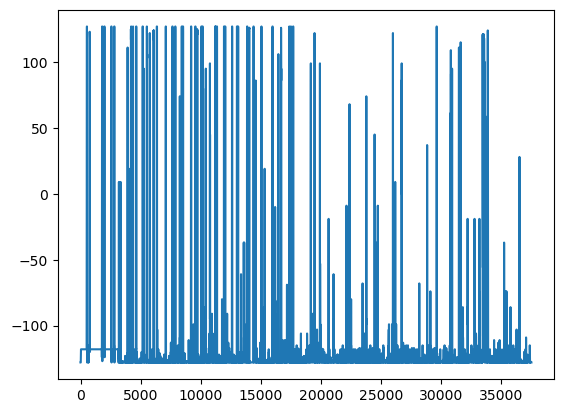

In [43]:
plt.plot(hw_acts_i2s)

In [44]:
len(hw_acts_i2s)

37498

In [45]:
20*60*16000/512

37500.0